In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format

Saving kaggle.json to kaggle.json
 35% 9.00M/25.7M [00:00<00:00, 59.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 102MB/s] 


In [ ]:
import zipfile
zp = zipfile.ZipFile('/content/imdb-dataset-sentiment-analysis-in-csv-format.zip','r')
zp.extractall()

zp = zipfile.ZipFile('/content/drive/MyDrive/glove.6B.zip','r')
zp.extractall()

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers


In [ ]:
word2idx = {}
glove_dict = {}
with open('/content/glove.6B.100d.txt','r') as g:
  for i,line in enumerate(g):
    word = line.split()[0]
    vec = np.array(line.split()[1:],dtype='float32')
    word2idx[word]=i
    glove_dict[word]=vec


In [ ]:
traindf = pd.read_csv('/content/Train.csv')
testdf = pd.read_csv('/content/Test.csv')
validdf = pd.read_csv('/content/Valid.csv')

print(traindf.head())
print(testdf.head())
print(validdf.head())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0
                                                text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of 

In [ ]:
def textcleaner(s):
  s = re.sub('[^a-zA-Z\s]','',s)
  s = s.lower()
  return s

traindf['cleaned_text'] = traindf['text'].apply(lambda x:textcleaner(x))
testdf['cleaned_text'] = testdf['text'].apply(lambda x:textcleaner(x))
validdf['cleaned_text'] = validdf['text'].apply(lambda x:textcleaner(x))

print(traindf.head())
print(testdf.head())
print(validdf.head())

                                                text  ...                                       cleaned_text
0  I grew up (b. 1965) watching and loving the Th...  ...  i grew up b  watching and loving the thunderbi...
1  When I put this movie in my DVD player, and sa...  ...  when i put this movie in my dvd player and sat...
2  Why do people who do not know what a particula...  ...  why do people who do not know what a particula...
3  Even though I have great interest in Biblical ...  ...  even though i have great interest in biblical ...
4  Im a die hard Dads Army fan and nothing will e...  ...  im a die hard dads army fan and nothing will e...

[5 rows x 3 columns]
                                                text  ...                                       cleaned_text
0  I always wrote this series off as being a comp...  ...  i always wrote this series off as being a comp...
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...  ...  st watched    out of dirsteve purcell typical .

In [ ]:
MAXLEN = 1000

def text2sequence(corpus):
  ohe_seq = []
  for line in corpus:
    line_seq = []
    try:
      for w in line.split():
        line_seq.append(word2idx[w])
    except:
      pass
    ohe_seq.append(line_seq)
  padded_seq = pad_sequences(ohe_seq,maxlen=MAXLEN)
  return np.array(padded_seq, dtype='int32')

valid_padded = text2sequence(validdf['cleaned_text'])
print(valid_padded.shape)

train_padded = text2sequence(traindf['cleaned_text'])
print(train_padded.shape, traindf.shape)

test_padded = text2sequence(testdf['cleaned_text'])
print(test_padded.shape, testdf.shape)

train_label = traindf['label'].values
test_label = testdf['label'].values
valid_label = validdf['label'].values

(5000, 1000)
(40000, 1000) (40000, 3)
(5000, 1000) (5000, 3)


In [ ]:
VOCAB_SIZE = len(glove_dict)
GLOVE_DIM = 100
embedding_matrix = np.zeros((VOCAB_SIZE,GLOVE_DIM),dtype='float32')

for w,v in glove_dict.items():
  idx = word2idx.get(w)
  embedding_matrix[idx] = v

embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=GLOVE_DIM,
                                   input_length=MAXLEN,
                                   weights=[embedding_matrix],
                                   trainable=False)


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(layers.Conv1D(filters=128,kernel_size=4,activation='relu'))
model.add(layers.MaxPool1D(pool_size=2,strides=2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(filters=32,kernel_size=4,activation='relu'))
model.add(layers.MaxPool1D(pool_size=2,strides=2))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

print(model.summary())


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         40000000  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 997, 128)          51328     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 498, 128)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 498, 128)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 495, 32)           16416     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 247, 32)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7904)             

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto")

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_padded,train_label,batch_size=64,epochs=20,callbacks=[callback],
          validation_data=(valid_padded,valid_label),validation_batch_size=32)

Epoch 1/20
625/625 [==============================] - 12s 18ms/step - loss: 0.7232 - accuracy: 0.5552 - val_loss: 0.5669 - val_accuracy: 0.6812
Epoch 2/20
625/625 [==============================] - 11s 18ms/step - loss: 0.5733 - accuracy: 0.6797 - val_loss: 0.5610 - val_accuracy: 0.6870
Epoch 3/20
625/625 [==============================] - 11s 18ms/step - loss: 0.5361 - accuracy: 0.6997 - val_loss: 0.5284 - val_accuracy: 0.7244
Epoch 4/20
625/625 [==============================] - 11s 18ms/step - loss: 0.5189 - accuracy: 0.7169 - val_loss: 0.5191 - val_accuracy: 0.7246
Epoch 5/20
625/625 [==============================] - 11s 18ms/step - loss: 0.5034 - accuracy: 0.7282 - val_loss: 0.5184 - val_accuracy: 0.7250
Epoch 6/20
625/625 [==============================] - 11s 18ms/step - loss: 0.5026 - accuracy: 0.7290 - val_loss: 0.5132 - val_accuracy: 0.7246
Epoch 7/20
625/625 [==============================] - 11s 18ms/step - loss: 0.4782 - accuracy: 0.7437 - val_loss: 0.5278 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


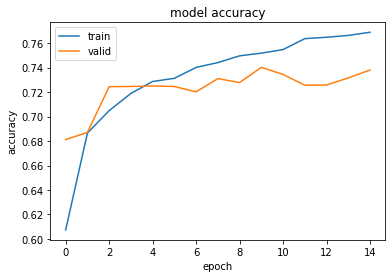

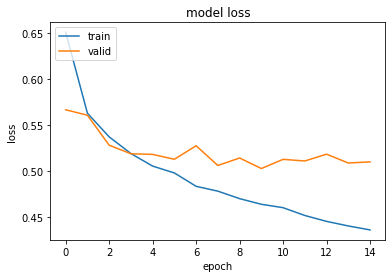

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(196))
model.add(layers.Dense(1,activation='sigmoid'))
print(model.summary())


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         40000000  
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 196)               233632    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 197       
Total params: 40,233,829
Trainable params: 233,829
Non-trainable params: 40,000,000
_________________________________________________________________
None


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(196,kernel_regularizer='l2',recurrent_regularizer='l2'))
model.add(layers.Dense(1,activation='sigmoid'))
print(model.summary())

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="auto")

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_padded,train_label,batch_size=64,epochs=30,callbacks=[callback],
          validation_data=(valid_padded,valid_label),validation_batch_size=32)


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         40000000  
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 196)               233632    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 197       
Total params: 40,233,829
Trainable params: 233,829
Non-trainable params: 40,000,000
_________________________________________________________________
None
Epoch 1/30
625/625 [==============================] - 49s 76ms/step - loss: 1.1611 - accuracy: 0.5783 - val_loss: 0.6464 - val_accuracy: 0.6480
Epoch 2/30
625/625 [==============================] - 47s 76ms/step - loss: 0.6326 - accuracy: 0.6619 - val_loss: 0.6179 - val_accuracy: 0.6824
Epoch 3/30
625/625 [==============================] - 48s 76ms/step - lo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


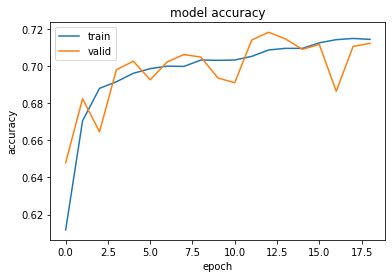

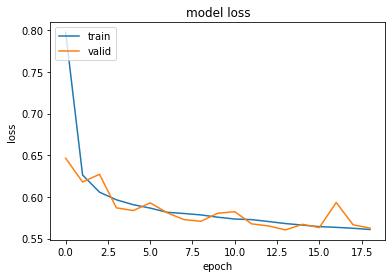

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()